In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from multiprocessing import Pool
from collections import namedtuple
pool = Pool()

## Reference : A Simulation Study on the Activation of Cardiac CaMKII delta-Isoform and Its Regulation by Phosphatases

Chiba H, Schneider NS, Matsuoka S, Noma A

Biophys J. 2008 Sep 01; 95(5) 2139-2149

DOI: 10.1529/biophysj.107.118505, PMID: 18502812, PMCID: PMC2517018

In [2]:
"""
Reference: 
A Simulation Study on the Activation of Cardiac CaMKIIδ Isoform and ItsRegulation by Phosphatases
Chiba et. al, 2008
DOI: 10.1529/biophysj.107.118505, PMID: 18502812, PMCID: PMC2517018
"""

def _mm(x, k):
    return x / (x + k)

def _hill(x, k, n):
    return _mm(x**n, k**n)

# Calmodulin model
def cam_sys(camca1, camca2, camca3, camca4, ca, cam_total, k1p, k1m, k2p, k2m, k3p, k3m, k4p, k4m):
    """ Calmodulin model """
    cam = cam_total - camca1 - camca2 - camca3 - camca4
    v1 = k1p * cam * ca - k1m * camca1
    v2 = k2p * camca1 * ca - k2m * camca2 
    v3 = k3p * camca2 * ca - k3m * camca3
    v4 = k4p * camca3 * ca - k4m * camca4
    dcamca1 = v1 - v2
    dcamca2 = v2 - v3
    dcamca3 = v3 - v4
    dcamca4 = v4
    return [dcamca1, dcamca2, dcamca3, dcamca4]

# CaMKII model
def camkii_sys(camkii_camca4, camkii_p_camca4, camkii_p, camca4, ca, camkii_total, atp, pp1, k_a, k_d, k_d_ca, k_d2, k_d_ca2, km_cam, kcat, km_atp, kcat_pp1, km_pp1):
    """ CaMKII model """
    camkii = camkii_total - camkii_camca4 - camkii_p_camca4 - camkii_p
    
    # Association of CaMKII and CaMCa4
    a1 = k_a * camca4 * camkii
    # Association of CaMKII-p and CaMCa4
    c2 = k_a * camca4 * camkii_p
    
    # Dissociation of CaMKII and CaMCa4
    phi_cam = _hill(ca, km_cam, 3)
    a2 = (k_d * phi_cam + k_d_ca * (1 - phi_cam)) * camkii_camca4
     # Dissociation of CaMKII-p and CaMCa4 (1000x slower)
    c1 = (k_d2 * phi_cam + k_d_ca2 * (1 - phi_cam)) * camkii_p_camca4
    
    # Autophosphorylation of CaMKII subunits
    p = 1 - (camkii / camkii_total)**2
    b1 = kcat * p * _mm(atp, km_atp) * camkii_camca4
    
    # Dephosphorylation by phosphorylase (PP1)
    b2 = kcat_pp1 * pp1 * _mm(camkii_p_camca4, km_pp1)
    d1 = kcat_pp1 * pp1 * _mm(camkii_p, km_pp1)
    
    v1 = a1 - a2
    v2 = b1 - b2
    v3 = c1 - c2
    v4 = d1
    dcamkii_camca4 = v1 - v2
    dcamkii_p_camca4 = v2 - v3
    dcamkii_p = v3 - v4
    return [dcamkii_camca4, dcamkii_p_camca4, dcamkii_p]

def rhs(t, y, cam_total, k1p, k1m, k2p, k2m, k3p, k3m, k4p, k4m, camkii_total, atp, pp1, k_a, k_d, k_d_ca, k_d2, k_d_ca2, km_cam, kcat, km_atp, kcat_pp1, km_pp1):
    camca1, camca2, camca3, camca4, camkii_camca4, camkii_p_camca4, camkii_p, ca = y
    
    v_cam = cam_sys(camca1, camca2, camca3, camca4, ca, cam_total, k1p, k1m, k2p, k2m, k3p, k3m, k4p, k4m)
    v_camkii = camkii_sys(camkii_camca4, camkii_p_camca4, camkii_p, camca4, ca, camkii_total, atp, pp1, k_a, k_d, k_d_ca, k_d2, k_d_ca2, km_cam, kcat, km_atp, kcat_pp1, km_pp1)
    dca = 0
    return v_cam + v_camkii + [dca] # Merge lists


In [3]:
# Reference constants from the original paper
K1 = 2.5
KM1 = KM2 = 0.05
K2 = 88.25
K3 = 12.5
KM3 = KM4 = 1.25
K4 = 250

K_A = 2.1
K_D_ALPHA = 1.4E-4
K_D_DELTA = 0.5 * K_D_ALPHA
K_D_CA_ALPHA = 1.9E-3
K_D_CA_DELTA = 0.5 * K_D_CA_ALPHA
K_D2_ALPHA = K_D_ALPHA * 1e-3
K_D2_DELTA = K_D_DELTA * 1e-3
K_D2_CA_ALPHA = K_D_CA_ALPHA * 1e-3
K_D2_CA_DELTA = K_D_CA_DELTA * 1e-3
KM_CAM = 3E-5
KCAT_0_ALPHA = 1E-5
KCAT_0_DELTA = 6 * KCAT_0_ALPHA
KCAT_30_ALPHA = 30 * KCAT_0_ALPHA
KCAT_30_DELTA = 6 * KCAT_30_ALPHA
KCAT_37_ALPHA = 3 * KCAT_30_ALPHA
KCAT_37_DELTA = 6 * KCAT_37_ALPHA
KM_ATP = 19.1E-3
KCAT_PP1 = 1.72E-3
KM_PP1 = 11.0E-3

# Substance concentrations
CAM_TOTAL = 6e-3
PP1 = 0.1E-3
CAMKII_TOTAL = 0.1E-3
ATP = 0.1

# Other constants
T_END = 4000000.0
DELTA = 0.01

# Params in the ODE
params = { 'cam_total': CAM_TOTAL,
           'k1p': K1,
           'k1m': KM1,
           'k2p': K2,
           'k2m': KM2,
           'k3p': K3,
           'k3m': KM3,
           'k4p': K4,
           'k4m': KM4,
           'camkii_total': CAMKII_TOTAL,
           'atp': ATP,
           'pp1': PP1,
           'k_a': K_A,
           'k_d': K_D_DELTA,
           'k_d_ca': K_D_CA_DELTA,
           'k_d2': K_D2_DELTA,
           'k_d_ca2': K_D2_CA_DELTA,
           'km_cam': KM_CAM,
           'kcat': KCAT_37_DELTA,
           'km_atp': KM_ATP,
           'kcat_pp1': KCAT_PP1,
           'km_pp1': KM_PP1}

# Initial conditions
y0 = [0.0, 0.0, 0.0, 0.0] + [0.0, 0.0, 0.0] + [1e-3]

# Ranges are 8 orders of magnitude apart, except for some linearly-spaced ones or strictly constant ones
param_ranges = {name: params[name] * np.logspace(-4, 4, num=100) for name in params}
param_ranges['atp'] = np.linspace(0, 1, num=100)
# Calcium ranges (0.1μM ~ 10μM)
ca_concs = np.logspace(-4, -2, num=100)

In [4]:
params

{'cam_total': 0.006,
 'k1p': 2.5,
 'k1m': 0.05,
 'k2p': 88.25,
 'k2m': 0.05,
 'k3p': 12.5,
 'k3m': 1.25,
 'k4p': 250,
 'k4m': 1.25,
 'camkii_total': 0.0001,
 'atp': 0.1,
 'pp1': 0.0001,
 'k_a': 2.1,
 'k_d': 7e-05,
 'k_d_ca': 0.00095,
 'k_d2': 6.999999999999999e-08,
 'k_d_ca2': 9.5e-07,
 'km_cam': 3e-05,
 'kcat': 0.0054,
 'km_atp': 0.0191,
 'kcat_pp1': 0.00172,
 'km_pp1': 0.011}

In [5]:
def _act_camk(sol, params):
    yend = sol[-1]
    return np.sum(yend[4:7]) / params['camkii_total']

def _phosphorylation(sol, params, KM_CAMKII = 0.15):
    """
    Get phosphorylation proportion from active CaMKII level.
    KM = 0.15 from the ORd model
    """
    camkii_act = _act_camk(sol, params)
    return _mm(camkii_act, KM_CAMKII)

# Relative sensitivity analysis

$Sensitivity = (\frac{dP}{P}) / (\frac{dS}{S})$

* In = Parameter(s)

* Out = Unphosphorylated proportion of CaMKII targets (complex I, mitochondrial creatine kinase)

Varying one parameter across 8 orders of magnitude at a time, plus varying calcium concentration, yielding a 2D sensitivity heat map.

In [6]:
ts = np.linspace(0, 2000000)
y0s = [[0.0] * 7 + [ca] for ca in ca_concs]

In [7]:
sol = odeint(lambda y, t: rhs(t, y, **params), y0, ts)
sol 

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e-03],
       [2.63317502e-04, 4.64755391e-04, 4.64755391e-06, 9.29510782e-07,
        4.70801557e-07, 5.31801339e-06, 5.20238466e-09, 1.00000000e-03],
       [2.63317502e-04, 4.64755391e-04, 4.64755391e-06, 9.29510782e-07,
        3.24463854e-07, 1.15969575e-05, 2.04855287e-08, 1.00000000e-03],
       [2.63317502e-04, 4.64755391e-04, 4.64755391e-06, 9.29510782e-07,
        2.70755716e-07, 1.75318104e-05, 4.03420269e-08, 1.00000000e-03],
       [2.63317502e-04, 4.64755391e-04, 4.64755391e-06, 9.29510782e-07,
        2.63190609e-07, 2.30348510e-05, 6.16789387e-08, 1.00000000e-03],
       [2.63317502e-04, 4.64755391e-04, 4.64755391e-06, 9.29510782e-07,
        2.53858326e-07, 2.81401882e-05, 8.29093895e-08, 1.00000000e-03],
       [2.63317502e-04, 4.64755391e-04, 4.64755391e-06, 9.29510782e-07,
        2.48863564e-07, 3.28570569e-05, 1.03236217e-07, 1.

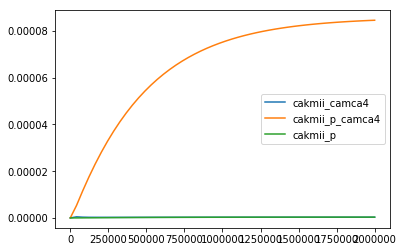

In [8]:
plt.figure()
#plt.plot(t, sol[0][:, 1], label="camca1")
plt.plot(ts, sol[:, 4], label="cakmii_camca4")
plt.plot(ts, sol[:, 5], label="cakmii_p_camca4")
plt.plot(ts, sol[:, 6], label="cakmii_p")
plt.legend(loc="best")

In [10]:
phosphorylated = np.asarray([_phosphorylation(odeint(lambda y, t: rhs(t, y, **params), y0, ts), params, KM_CAMKII = 0.15) for y0 in y0s])
phosphorylated

array([1.58462003e-05, 1.97096890e-05, 2.44381948e-05, 3.02181029e-05,
       3.72615792e-05, 4.58426573e-05, 5.62794647e-05, 6.89489179e-05,
       8.43199145e-05, 1.03006140e-04, 1.25661029e-04, 1.53189359e-04,
       1.86565282e-04, 2.27088008e-04, 2.76343998e-04, 3.36257706e-04,
       4.09099048e-04, 4.98520465e-04, 6.07483063e-04, 7.41306763e-04,
       9.06991878e-04, 1.11150356e-03, 1.36702348e-03, 1.68924941e-03,
       2.09781624e-03, 2.62160166e-03, 3.31049671e-03, 4.22929709e-03,
       5.49163117e-03, 7.30508039e-03, 1.00513456e-02, 1.46114113e-02,
       2.33562742e-02, 4.43678162e-02, 1.01435488e-01, 2.06292667e-01,
       3.26504244e-01, 4.35693884e-01, 5.25788695e-01, 5.98733801e-01,
       6.56538581e-01, 7.03039314e-01, 7.39381783e-01, 7.68426922e-01,
       7.91260627e-01, 8.09207515e-01, 8.23184902e-01, 8.33862909e-01,
       8.41952002e-01, 8.47977864e-01, 8.52480599e-01, 8.55795223e-01,
       8.58322796e-01, 8.60276466e-01, 8.61842063e-01, 8.63115027e-01,
      

In [11]:
# Sensitivity for Calcium
y0s_ca = [[0.0] * 7 + [ca * (1 + DELTA)] for ca in ca_concs]
phosphorylated_ca = np.asarray([_phosphorylation(odeint(lambda y, t: rhs(t, y, **params), y0, ts), params, KM_CAMKII = 0.15) for y0 in y0s_ca])
sensitivity = (phosphorylated_ca - phosphorylated) / DELTA

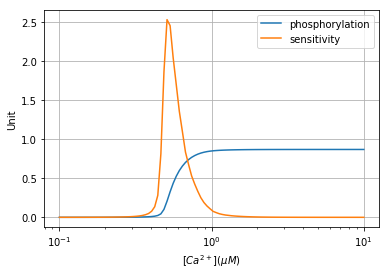

In [12]:
# dynamic range: Ca = 0.4~1 μM
plt.figure()
plt.semilogx(ca_concs * 1e3, phosphorylated, label="phosphorylation")
plt.semilogx(ca_concs * 1e3, sensitivity, label="sensitivity")
plt.xlabel(r'$[Ca^{2+}](μM)$')
plt.ylabel('Unit')
plt.legend(loc='best')
plt.grid(True)

Relative sensitivity was noted between 0.4 $\mu M$ and 0.9 $\mu M$

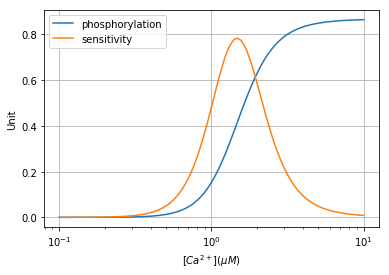

In [13]:
# Calcium sensitivity without ATP
# Shifted to right, wider, less amplitude
params_atp = params.copy()
params_atp['atp'] = 0.0
phosphorylated = np.asarray([_phosphorylation(odeint(lambda y, t: rhs(t, y, **params_atp), y0, ts), params_atp, KM_CAMKII = 0.15) for y0 in y0s])
phosphorylated_ca = np.asarray([_phosphorylation(odeint(lambda y, t: rhs(t, y, **params_atp), y0, ts), params_atp, KM_CAMKII = 0.15) for y0 in y0s_ca])
sensitivity = (phosphorylated_ca - phosphorylated) / DELTA
plt.figure()
plt.semilogx(ca_concs * 1e3, phosphorylated, label="phosphorylation")
plt.semilogx(ca_concs * 1e3, sensitivity, label="sensitivity")
plt.xlabel(r'$[Ca^{2+}](μM)$')
plt.ylabel('Unit')
plt.legend(loc='best')
plt.grid(True)

Relative sensitivity was noted between 0.8 $\mu M$ and 10 $\mu M$

In [53]:
def calc_sensitivities(param_original, param_name, param_val, rhs, ca_concs, T_END=2000, DELTA=0.01):
    """ Generalized sensitivity map function """
    local_params = param_original.copy()
    local_params[param_name] = param_val
    y0s = [[0.0] * 7 + [ca] for ca in ca_concs]
    phosphorylated = [_phosphorylation(odeint(lambda y, t: rhs(t, y, **local_params), y0, t), local_params, KM_CAMKII=0.15) for y0 in y0s]
    phosphorylated = np.asarray(phosphorylated)
    local_params[param_name] = param_val * (1 + DELTA)
    phosphorylated_new = [_phosphorylation(odeint(lambda y, t: rhs(t, y, **local_params), y0, t), local_params, KM_CAMKII=0.15) for y0 in y0s]
    phosphorylated_new = np.asarray(phosphorylated_new)
    sensitivities = ( phosphorylated_new - phosphorylated) / DELTA
    return sensitivities

In [59]:
def plot_sensitivities(sensitivities, ca_concs, param_ranges, param_name, log_scale=True, SCALE=1.0):
    """ Plot sensitivity map """
    plt.figure()
    # min_sense = np.min(sensitivities)
    # max_sense = np.max(sensitivities)
    # sense_range = max(abs(min_sense), abs(max_sense))
    plt.pcolormesh(ca_concs * 1e3, param_ranges[param_name], sensitivities, cmap=plt.cm.bwr, vmax=SCALE, vmin=-SCALE)
    plt.xlabel(r'$[Ca^{2+}]( \mu M )$')
    plt.xscale('log')
    if log_scale:
        plt.yscale('log')
    plt.ylabel(param_name.upper())
    return plt.colorbar()

The code was running on Python 3.7 in the Jupyter notebook on a workstation with dual Xeon E5-2620 CPUs.

In [55]:
# Generator of arguments
args = {name: [(params, name, param_val, rhs, ca_concs, 2000000, 0.01) for param_val in param_ranges[name]] for name in params}

In [56]:
# Multiprocessing (using all CPU cores)
pool = Pool()
param_sensitivities = {}
for name in params:
    param_sensitivities[name] = np.array(pool.starmap(calc_sensitivities, args[name])).reshape(-1, ca_concs.shape[0])
    print(name, 'is completed.')
pool.close()
print('Finished')

/home/sosiristseng/miniconda3/envs/sci/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/sosiristseng/miniconda3/envs/sci/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


cam_total is completed.
k1p is completed.
k1m is completed.
k2p is completed.
k2m is completed.
k3p is completed.
k3m is completed.
k4p is completed.
k4m is completed.
camkii_total is completed.
atp is completed.
pp1 is completed.
k_a is completed.
k_d is completed.
k_d_ca is completed.
k_d2 is completed.
k_d_ca2 is completed.
km_cam is completed.
kcat is completed.
km_atp is completed.
kcat_pp1 is completed.
km_pp1 is completed.
Finished


In [57]:
param_sensitivities['atp']

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.58968444e-09,  7.43699619e-09,  1.11056992e-08, ...,
         2.91967820e-05,  2.67051575e-05,  2.44755820e-05],
       [ 6.84366987e-09,  8.81271143e-09,  1.53839948e-08, ...,
         1.46766489e-05,  1.34241225e-05,  1.23033324e-05],
       ...,
       [ 4.45392799e-10, -3.25898204e-10, -1.56514740e-08, ...,
         3.04204129e-07,  2.78242152e-07,  2.55010935e-07],
       [ 5.62965570e-10,  3.47615985e-09,  1.22952183e-09, ...,
         3.01100311e-07,  2.75403278e-07,  2.52409049e-07],
       [ 3.26658641e-10, -2.65361148e-09,  1.22450559e-08, ...,
         2.98059255e-07,  2.72621747e-07,  2.49859766e-07]])

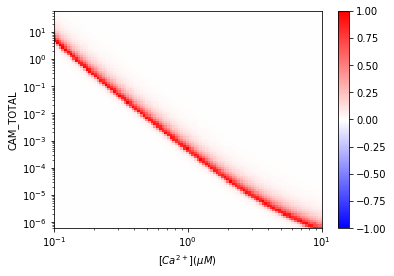

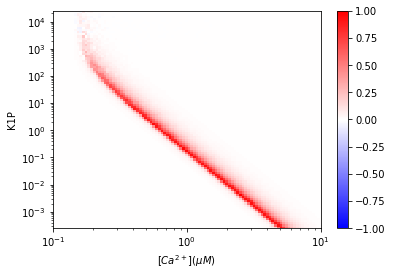

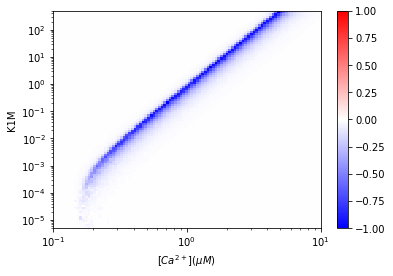

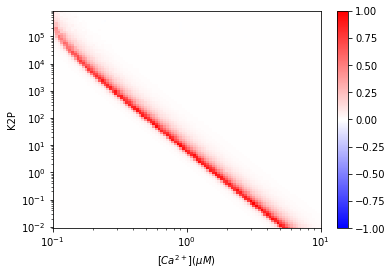

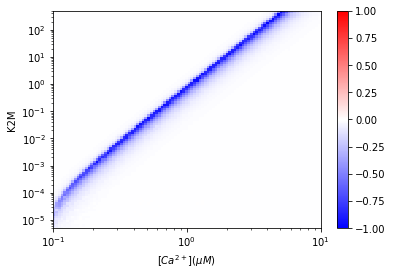

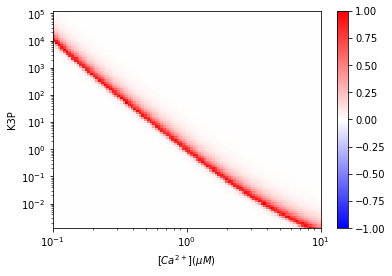

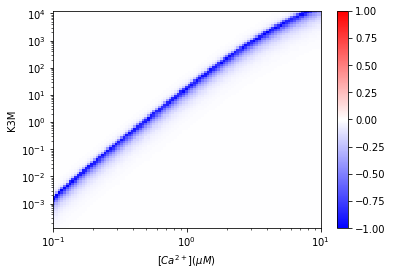

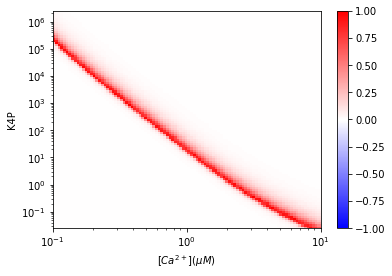

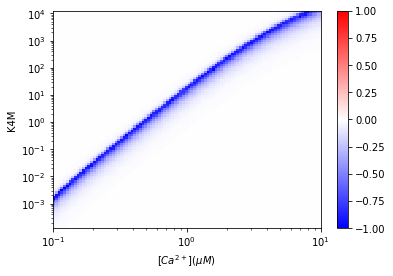

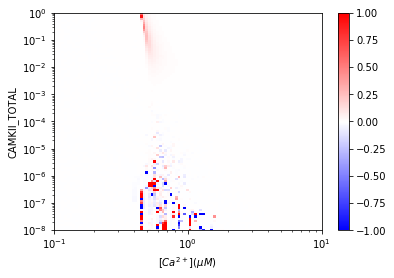

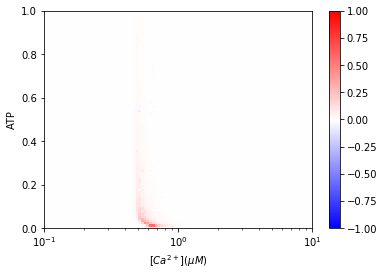

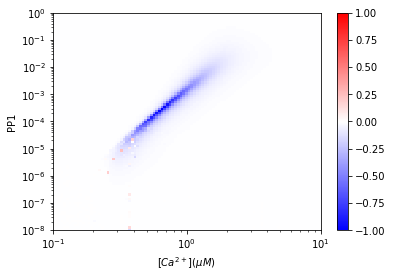

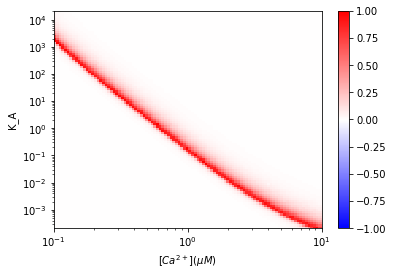

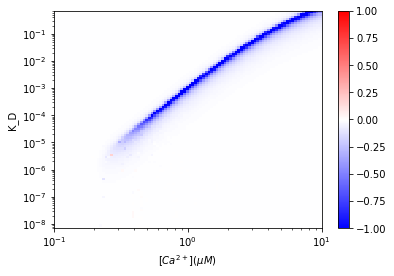

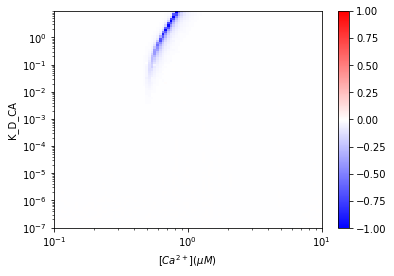

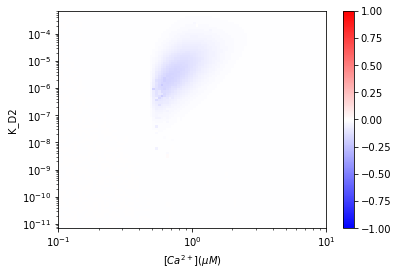

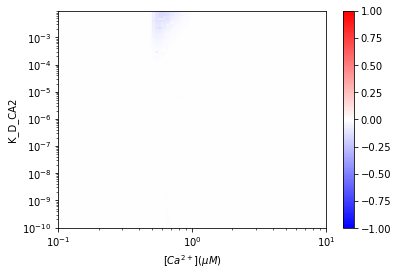

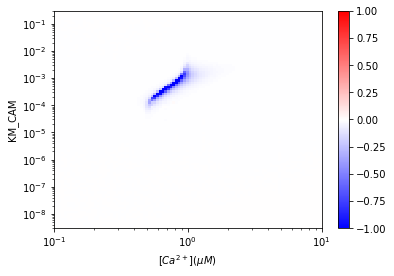

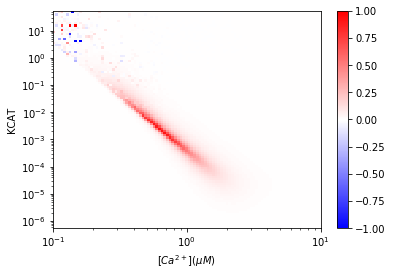

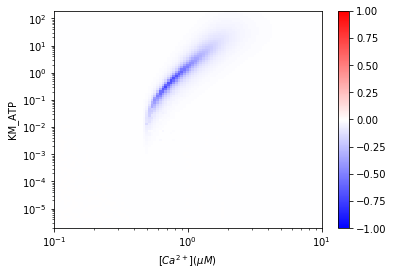

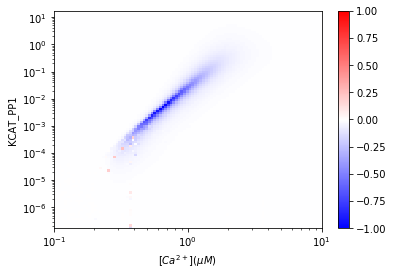

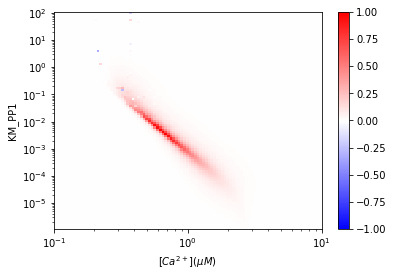

In [60]:
for name in param_sensitivities:
    plot_sensitivities(param_sensitivities[name], ca_concs, param_ranges, name, name not in ('atp'))

In [61]:
# Disable C1 => K_DISSO2 = K_DISSO_CA2 = 0
# Params for the model
params_new = { 'cam_total': CAM_TOTAL,
           'k1p': K1,
           'k1m': KM1,
           'k2p': K2,
           'k2m': KM2,
           'k3p': K3,
           'k3m': KM3,
           'k4p': K4,
           'k4m': KM4,
           'camkii_total': CAMKII_TOTAL,
           'atp': ATP,
           'pp1': PP1,
           'k_a': K_A,
           'k_d': K_D_DELTA,
           'k_d_ca': K_D_CA_DELTA,
           'k_d2': 0.0,
           'k_d_ca2': 0.0,
           'km_cam': KM_CAM,
           'kcat': KCAT_37_DELTA,
           'km_atp': KM_ATP,
           'kcat_pp1': KCAT_PP1,
           'km_pp1': KM_PP1}

# Generator of arguments
args_new = {name: [(params_new, name, param_val, rhs, ca_concs, 2000000, 0.01) for param_val in param_ranges[name]] for name in params if (name != 'k_d2' or name != 'k_d_ca2')}

In [63]:
# Multiprocessing (using all CPU cores)
param_sensitivities = {}
pool = Pool()
for name in params:
    param_sensitivities[name] = np.array(pool.starmap(calc_sensitivities, args_new[name])).reshape(-1, ca_concs.shape[0])
    print(name, 'is completed.')
pool.close()
print('Finished')

/home/sosiristseng/miniconda3/envs/sci/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/sosiristseng/miniconda3/envs/sci/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


cam_total is completed.
k1p is completed.
k1m is completed.
k2p is completed.
k2m is completed.
k3p is completed.
k3m is completed.
k4p is completed.
k4m is completed.
camkii_total is completed.
atp is completed.
pp1 is completed.
k_a is completed.
k_d is completed.
k_d_ca is completed.
k_d2 is completed.
k_d_ca2 is completed.
km_cam is completed.
kcat is completed.
km_atp is completed.
kcat_pp1 is completed.
km_pp1 is completed.
Finished


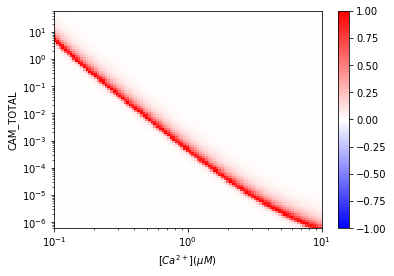

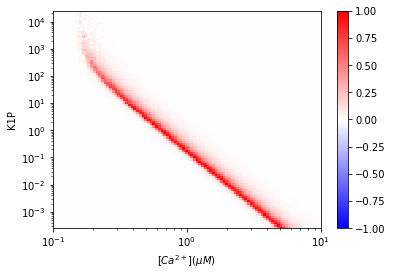

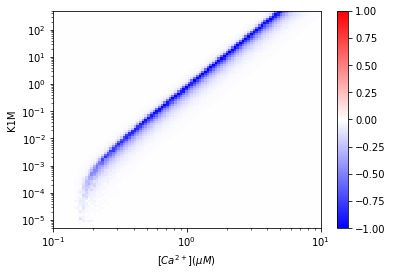

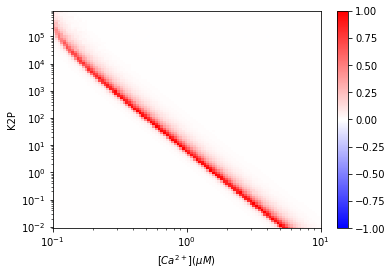

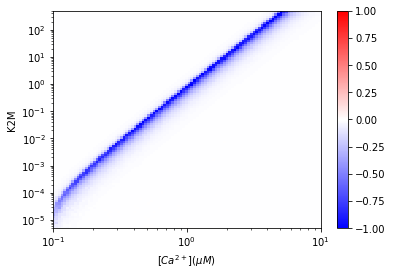

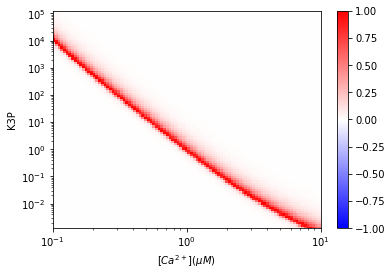

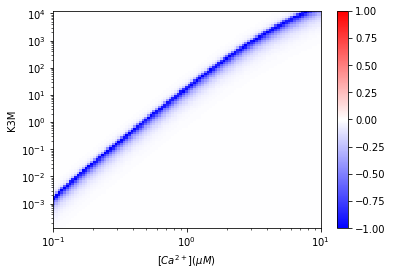

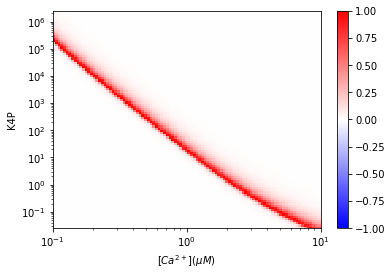

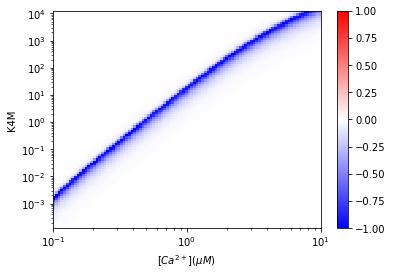

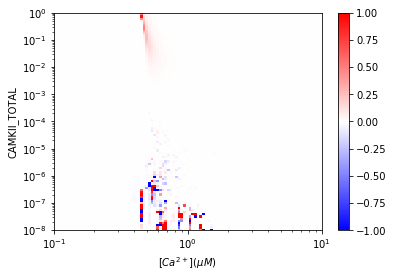

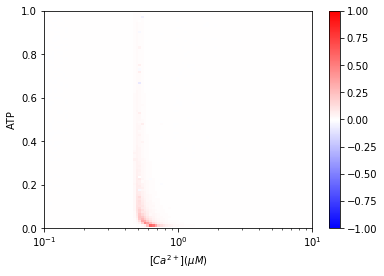

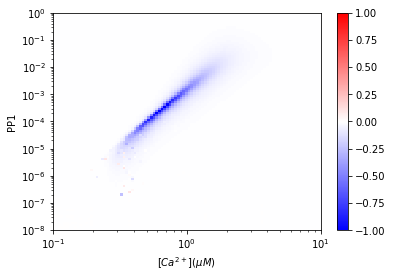

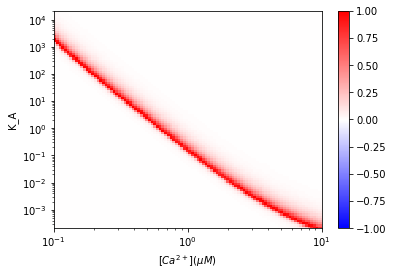

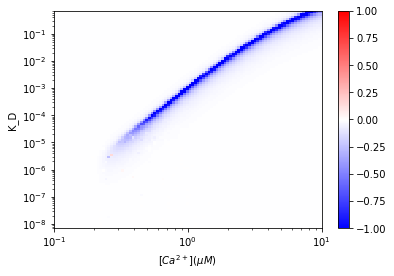

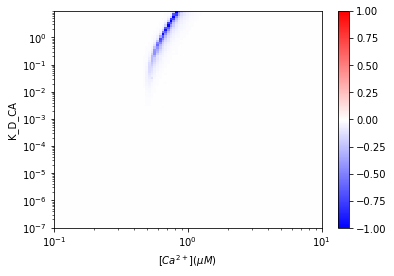

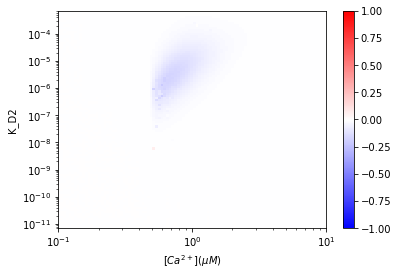

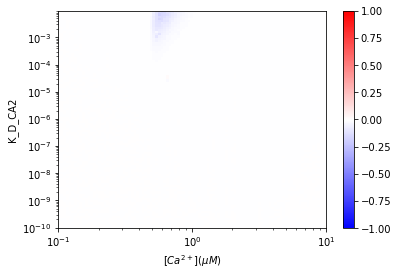

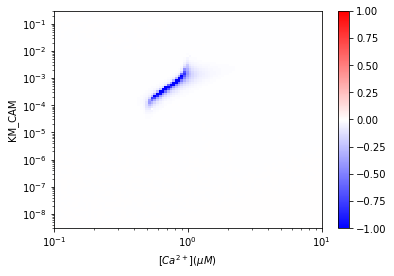

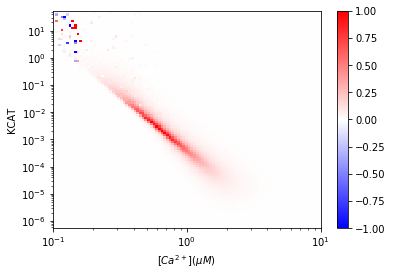

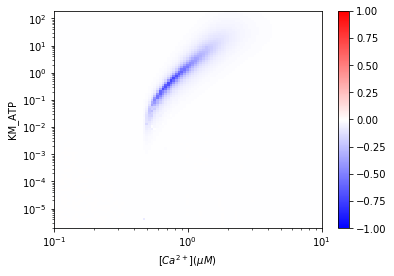

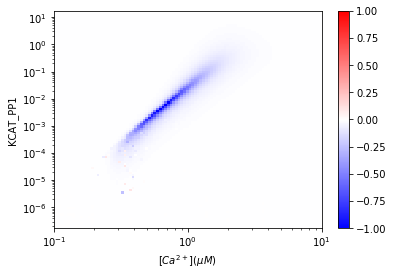

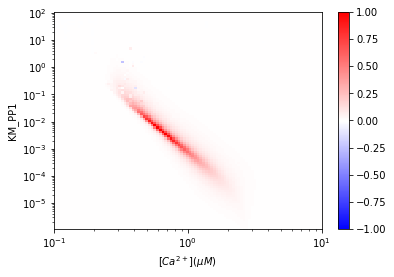

In [64]:
# Plot sensitivities
for name in param_sensitivities:
    plot_sensitivities(param_sensitivities[name], ca_concs, param_ranges, name, name not in ('atp'))